In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import math
import sqlite3
import zipfile
import warnings
warnings.filterwarnings('ignore')

In [2]:
movie = pd.read_csv('../zippedData/tmdb.movies.csv.gz')
movie_info = pd.read_csv('../zippedData/rt.movie_info.tsv.gz',sep='\t', compression='gzip')
movie_review = pd.read_csv('../zippedData/rt.reviews.tsv.gz', sep='\t', encoding='latin1')
movie_gross = pd.read_csv('../zippedData/bom.movie_gross.csv.gz')
movie_budget = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')
conn = sqlite3.connect('im.db.zip')
#specify the path to the zip file
zip_file_path = '../zippedData/im.db.zip'

#Extract the SQLite database file from the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('unzippedData')

#connect to extracted SQLite database
database_path = 'unzippedData/im.db'
conn = sqlite3.connect(database_path)

In [3]:
# drop "Unnamed: 0" and "original_title" columns from the "movie" dataframe
movie.drop(["Unnamed: 0", "original_title"], axis=1, inplace=True)

# convert "release_date" column to datetime format
movie["release_date"] = pd.to_datetime(movie["release_date"])

# create "year" and "month" columns from "release_date" column
movie["year"] = movie["release_date"].dt.year
movie["month"] = movie["release_date"].dt.month

In [4]:
# convert "production_budget", "domestic_gross" and "worldwide_gross" columns to int64 format
movie_budget["production_budget"] = movie_budget["production_budget"].str.replace(",", "").str.replace("$", "").astype("int64")
movie_budget["domestic_gross"] = movie_budget["domestic_gross"].str.replace(",", "").str.replace("$", "").astype("int64")
movie_budget["worldwide_gross"] = movie_budget["worldwide_gross"].str.replace(",", "").str.replace("$", "").astype("int64")

# create "foreign_gross" column by subtracting "domestic_gross" from "worldwide_gross"
movie_budget["foreign_gross"] = movie_budget["worldwide_gross"] - movie_budget["domestic_gross"]

# create "total_profit" column by subtracting "worldwide_gross" from "production_budget"
movie_budget["total_profit"] = movie_budget["worldwide_gross"] - movie_budget["production_budget"]

# create "total_profit_margin" column by dividing "total_profit" by "production_budget"
movie_budget["total_profit_margin"] = movie_budget["total_profit"] / movie_budget["production_budget"]

In [5]:
movie_basics = pd.read_sql("""
SELECT *
FROM movie_basics
JOIN directors
    USING(movie_id)
JOIN persons
    USING(person_id)
JOIN principals
    USING(person_id)
WHERE category = 'director'
""",conn)

In [6]:
movie_basics.drop_duplicates(subset="primary_title", keep="last", inplace=True)

In [7]:
# drop duplicates from movie_basics based on movie_id column
movie_basics.drop_duplicates(subset="primary_title", keep="last", inplace=True)

In [8]:
# merge movie_basics and movie_budget on movie and primary_title
movie_df = pd.merge(movie_basics, movie_budget, left_on="primary_title", right_on="movie", how="inner")

In [9]:
movie_df.drop(["job", "characters", "movie_id", "primary_profession", "person_id", "primary_title", "original_title"], axis=1, inplace=True)

In [10]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2314 entries, 0 to 2313
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   start_year           2314 non-null   int64  
 1   runtime_minutes      2122 non-null   float64
 2   genres               2302 non-null   object 
 3   primary_name         2314 non-null   object 
 4   birth_year           1288 non-null   float64
 5   death_year           18 non-null     float64
 6   ordering             2314 non-null   int64  
 7   category             2314 non-null   object 
 8   id                   2314 non-null   int64  
 9   release_date         2314 non-null   object 
 10  movie                2314 non-null   object 
 11  production_budget    2314 non-null   int64  
 12  domestic_gross       2314 non-null   int64  
 13  worldwide_gross      2314 non-null   int64  
 14  foreign_gross        2314 non-null   int64  
 15  total_profit         2314 non-null   i

In [11]:
# Create a boolean mask for movies with total_gross over the high budget threshold
#https://www.studiobinder.com/blog/production-budget/

high_budget = 50000000
low_budget = 5000000

high_budget_mask = movie_df['production_budget'] > high_budget
low_budget_mask = movie_df['production_budget']< low_budget
budget_mask = (movie_df['production_budget'] >= low_budget) & (movie_df['production_budget'] <= high_budget)

# Create a new dataframe for high budget movies
high_budget = movie_df[high_budget_mask]
low_budget = movie_df[low_budget_mask]
mid_budget = movie_df[budget_mask]

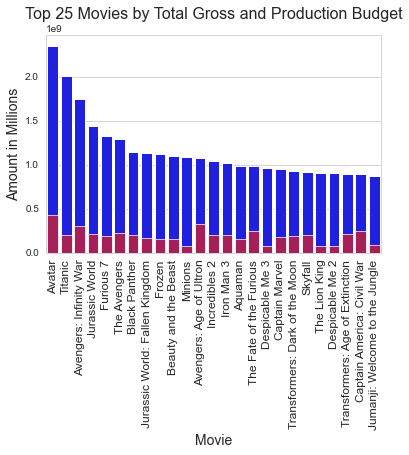

<Figure size 864x864 with 0 Axes>

In [12]:
# sort dataframe by total gross and select top 50 movies
top_50 = movie_df.sort_values(by='total_profit', ascending=False).head(25)

sns.set_style('whitegrid')

# create stacked bar plot of total gross and production budget
sns.barplot(x='movie', y='total_profit', data=top_50, color='blue')
sns.barplot(x='movie', y='production_budget', data=top_50, color='red', alpha=0.7, estimator=sum)

# add labels and title
plt.xlabel('Movie', fontsize=14)
plt.ylabel('Amount in Millions', fontsize=14)
plt.title('Top 25 Movies by Total Gross and Production Budget', fontsize=16)

# rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=12)

# increase figure size
plt.figure(figsize=(12,12))

# display plot
plt.show()

In [13]:
# sort dataframe by total gross and select top 50 movies
top_25_high = high_budget.sort_values(by='total_gross', ascending=False).head(25)

sns.set_style('whitegrid')

# create stacked bar plot of total gross and production budget
sns.barplot(x='movie', y='total_gross', data=top_25_high, color='blue')
sns.barplot(x='movie', y='production_budget', data=top_25_high, color='red', alpha=0.7, estimator=sum)

# add labels and title
plt.xlabel('Movie', fontsize=14)
plt.ylabel('Amount in Millions', fontsize=14)
plt.title('Top 25 Movies by Total Gross and High Production Budget', fontsize=16)

# rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=12)

# increase figure size
plt.figure(figsize=(12,12))

# display plot
plt.show()

KeyError: 'total_gross'

In [ ]:
# sort dataframe by total gross and select top 50 movies
top_25_mid = mid_budget.sort_values(by='total_gross', ascending=False).head(25)

sns.set_style('whitegrid')

# create stacked bar plot of total gross and production budget
sns.barplot(x='movie', y='total_gross', data=top_25_mid, color='blue')
sns.barplot(x='movie', y='production_budget', data=top_25_mid, color='red', alpha=0.7, estimator=sum)

# add labels and title
plt.xlabel('Movie', fontsize=14)
plt.ylabel('Amount in Millions', fontsize=14)
plt.title('Top 25 Movies by Total Gross and Mid Production Budget', fontsize=16)

# rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=12)

# increase figure size
plt.figure(figsize=(12,12))

# display plot
plt.show()

In [ ]:
# sort dataframe by total gross and select top 50 movies
top_25_low = low_budget.sort_values(by='total_gross', ascending=False).head(25)

sns.set_style('whitegrid')

# create stacked bar plot of total gross and production budget
sns.barplot(x='movie', y='total_gross', data=top_25_low, color='blue')
sns.barplot(x='movie', y='production_budget', data=top_25_low, color='red', alpha=0.7, estimator=sum)

# add labels and title
plt.xlabel('Movie', fontsize=14)
plt.ylabel('Amount in Millions', fontsize=14)
plt.title('Top 25 Movies by Total Gross and Low Production Budget', fontsize=16)

# rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=12)

# increase figure size
plt.figure(figsize=(12,12))

# display plot
plt.show()

In [ ]:
import seaborn as sns

# create a new dataframe with total gross and year
total_gross_year = movie_money[['total_gross', 'year']].copy()
total_gross_year['year'] = total_gross_year['year']

# plot distribution plot of total gross by year
sns.lineplot(data=total_gross_year, x='year', y='total_gross')

In [ ]:
import seaborn as sns

# create a new dataframe with total gross and year
total_gross_month = movie_money[['total_gross', 'month']].copy()
total_gross_month['month'] = total_gross_year['month']

# plot distribution plot of total gross by year
sns.lineplot(data=total_gross_month, x='month', y='total_gross')

In [ ]:
pd.read_sql("""
SELECT *
FROM movie_basics
""",conn)